<a href="https://colab.research.google.com/github/yorketh/machine-learning/blob/master/BankMarketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook is devoted to predictive data anlysis of a bank's marketing campaign in order to derive insights regrding the campaign success factors

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, \
precision_recall_curve, auc, precision_score, recall_score
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn import preprocessing
import xgboost
import sklearn
from xgboost import XGBClassifier
import calendar

This notebook is mostly based on the Asad Mumtaz Scorecard [tutorial](https://towardsdatascience.com/how-to-develop-a-credit-risk-model-and-scorecard-91335fc01f03) for credit risk estimation. General approach, functions and some comments were used.

Different approaches were outlined afterwards as well.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data.txt', sep="\t")

In [ ]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
#NaN values are seemingly denoted as 'unknown'
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [ ]:
for col in data.columns:
  print(f'% of nan in {col}: ', len([i for i in data[col] if i=='unknown'])/len(data[col])*100)

% of nan in age:  0.0
% of nan in job:  0.6370131162770122
% of nan in marital:  0.0
% of nan in education:  4.1074074893278185
% of nan in default:  0.0
% of nan in balance:  0.0
% of nan in housing:  0.0
% of nan in loan:  0.0
% of nan in contact:  28.798301298356595
% of nan in day:  0.0
% of nan in month:  0.0
% of nan in duration:  0.0
% of nan in campaign:  0.0
% of nan in pdays:  0.0
% of nan in previous:  0.0
% of nan in poutcome:  81.74780473778506
% of nan in y:  0.0


In [ ]:
le = preprocessing.LabelEncoder()

In [ ]:
#transform target variable
data['y'] = le.fit_transform(data['y'])
#data['month'] = data['month'].apply(lambda x: list(calendar.month_abbr).index(x.capitalize()))

In [ ]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [ ]:
data[data=='unknown'] = np.nan

In [ ]:
#data = data.sort_values(['month', 'day'])

In [ ]:
data.pdays.max()

871

In [ ]:
#replace -1 with 1000 for clients never contacted
data['pdays'] = data['pdays'].apply(lambda x: 1000 if x==-1 else x)

In [ ]:
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,1000,0,NaN,0
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,1000,0,NaN,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,1000,0,NaN,0
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,1000,0,NaN,0
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,1000,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,1000,0,NaN,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,1000,0,NaN,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,1000,0,NaN,0


In [ ]:
#function to analyze target mean with time
def plot_ybins(target, step=1000):
  n = 0
  bins, means = [], []
  while n<len(target):
    means.append(target[n:n+step].mean())
    n+=step
    bins.append(n)

  plt.plot(bins, means)
  plt.show()


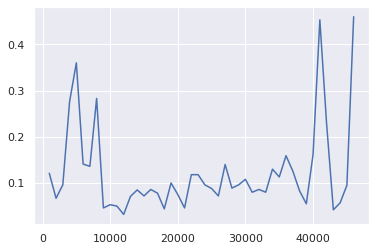

In [ ]:
data_calendar = data.copy()
data_calendar['month'] = data_calendar['month'].apply(lambda x: list(calendar.month_abbr).index(x.capitalize()))
data_calendar = data_calendar.sort_values(['month', 'day'])
plot_ybins(data_calendar.y, step=1000)

There is no clear trand visible. Let's check by month

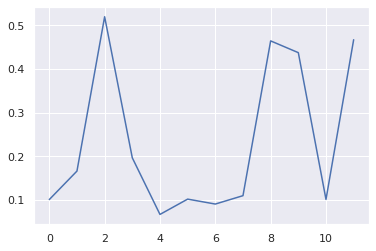

In [ ]:
plt.plot(range(12), data_calendar.groupby('month').mean().y)

Some spikes can be seen, but it's unclear whether they are seasonal. For now, let's assume that success rate will remain appr the same in production and make train-test split in stratified manner.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data.y, test_size = 0.2, random_state = 42, stratify = data.y)

In [ ]:
y_train.mean(), y_test.mean()

(0.11698186241981863, 0.11699657193409267)

In [ ]:
#categorical and numerical features
train_cat = X_train.select_dtypes(include = 'object').copy()
train_num = X_train.select_dtypes(include = 'number').copy()

In [ ]:
train_cat

,job,marital,education,default,housing,loan,contact,month,poutcome
24001,technician,divorced,secondary,no,no,no,telephone,aug,NaN
43409,student,single,secondary,no,no,no,cellular,apr,failure
20669,technician,single,secondary,no,yes,no,cellular,aug,NaN
18810,unemployed,married,secondary,no,no,no,telephone,jul,NaN
23130,technician,married,secondary,no,no,no,cellular,aug,NaN
...,...,...,...,...,...,...,...,...,...
17958,blue-collar,married,secondary,no,yes,no,cellular,jul,NaN
15941,admin.,single,secondary,no,yes,no,cellular,jul,NaN
16952,blue-collar,married,secondary,no,yes,no,cellular,jul,NaN
34781,management,single,tertiary,no,yes,no,cellular,may,NaN


Chi-squared test to determine the most suitable categorical variables

In [ ]:
chi2_check = {}

for column in train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,job,0.000000
1,marital,0.000000
2,education,0.000000
3,housing,0.000000
4,loan,0.000000
5,month,0.000000
6,poutcome,0.000000
7,default,0.000004
8,contact,0.259560


We'll use first 7 categorical features

In [ ]:
train_num

,age,balance,day,duration,campaign,pdays,previous
24001,36,861,29,140,2,1000,0
43409,24,4126,5,907,4,185,7
20669,44,244,12,1735,4,1000,0
18810,48,0,31,35,11,1000,0
23130,38,257,26,57,10,1000,0
...,...,...,...,...,...,...,...
17958,50,917,30,58,2,1000,0
15941,36,22,22,77,5,1000,0
16952,45,79,25,98,1,1000,0
34781,27,2559,6,227,1,1000,0


In [ ]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
train_num.fillna(train_num.mean(), inplace = True)
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(train_num, y_train)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': train_num.columns.values, 
                                     'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,duration,6756.112833,0.000000e+00
1,pdays,1145.677863,0.000000e+00
2,previous,287.756189,0.000000e+00
3,campaign,188.346066,0.000000e+00
4,balance,109.833496,0.000000e+00
5,day,25.598091,4.225000e-07
6,age,22.085250,2.617700e-06


We'll use first 5 numerical features

In [ ]:
top_num_features = ANOVA_F_table.iloc[:5,0].to_list()
# calculate pair-wise correlations between them
corrmat = train_num[top_num_features].corr()
corrmat

,duration,pdays,previous,campaign,balance
duration,1.000000,-0.001497,-0.000790,-0.086704,0.021114
pdays,-0.001497,1.000000,-0.507440,0.107981,-0.037814
previous,-0.000790,-0.507440,1.000000,-0.031240,0.017328
campaign,-0.086704,0.107981,-0.031240,1.000000,-0.014405
balance,0.021114,-0.037814,0.017328,-0.014405,1.000000


We naturally have multicollinearity between pdays and previous features. The more contacts have been performed previously the less days have passed since the last contact. Let's first try to include both features for prediction.

# WoE+LogReg

Peforming WoE/IV analysis. It allows to determine the relationships between separate features and target variables, thus allowing to understand how distinctive each feature is in regard to the outcome and how changing it helps to change the outcome. If each feature category/bin has appr the same proportions for good among good and bad among bad, this doesn't really allow us to use this feature for modelling as there is no value to implement a clean split on and to connect different feature values to different outcome.

In order to calculate WoE, let's perform OHE.

In [ ]:
# function to create dummy variables
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

train_dummy = dummy_creation(X_train, train_cat.columns)

In [ ]:
# The function takes 3 arguments: a dataframe (X_train_prepr), a string (column name), and a dataframe (y_train_prepr).
# The function returns a dataframe as a result.
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    # categories, number of rows, mean target value for each
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [ ]:
sns.set()
# Below we define a function for plotting WoE across categories that takes 2 arguments: a dataframe and a number.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

In [ ]:
df_temp = woe_discrete(train_dummy, train_cat.columns[0], y_train)
df_temp

,job,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,blue-collar,7830,0.072925,0.217899,571.0,7259.0,0.135855,0.228767,-0.521113,NaN,NaN,0.160128
1,housemaid,1013,0.083909,0.028191,85.0,928.0,0.020224,0.029246,-0.368885,0.010985,0.152228,0.160128
2,entrepreneur,1186,0.085160,0.033005,101.0,1085.0,0.024030,0.034194,-0.352719,0.001251,0.016166,0.160128
3,services,3348,0.089008,0.093171,298.0,3050.0,0.070902,0.096121,-0.304308,0.003848,0.048411,0.160128
4,technician,6068,0.109262,0.168865,663.0,5405.0,0.157744,0.170338,-0.076809,0.020253,0.227499,0.160128
5,self-employed,1243,0.114240,0.034591,142.0,1101.0,0.033785,0.034698,-0.026652,0.004978,0.050158,0.160128
6,admin.,4141,0.122917,0.115239,509.0,3632.0,0.121104,0.114462,0.056405,0.008677,0.083056,0.160128
7,management,7511,0.138597,0.209022,1041.0,6470.0,0.247680,0.203902,0.194501,0.015680,0.138096,0.160128
8,unemployed,1024,0.154297,0.028497,158.0,866.0,0.037592,0.027292,0.320206,0.015700,0.125704,0.160128
9,retired,1812,0.229581,0.050426,416.0,1396.0,0.098977,0.043995,0.810815,0.075284,0.490609,0.160128


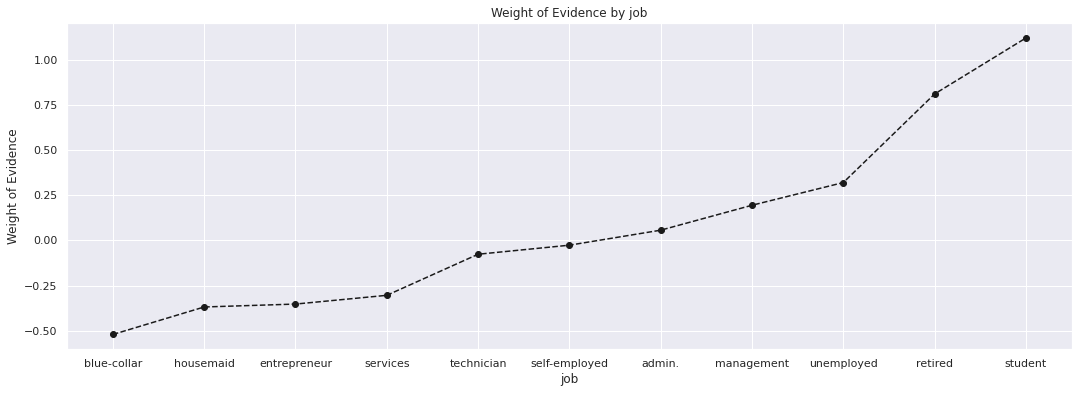

In [ ]:
plot_by_woe(df_temp)

In [ ]:
df_temp = woe_discrete(train_dummy, train_cat.columns[1], y_train)
df_temp

,marital,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,married,21771,0.100363,0.601941,2185.0,19586.0,0.516426,0.613270,-0.171872,NaN,NaN,0.043026
1,divorced,4170,0.122542,0.115295,511.0,3659.0,0.120775,0.114569,0.052751,0.022179,0.224624,0.043026
2,single,10227,0.150093,0.282764,1535.0,8692.0,0.362798,0.272161,0.287454,0.027551,0.234703,0.043026


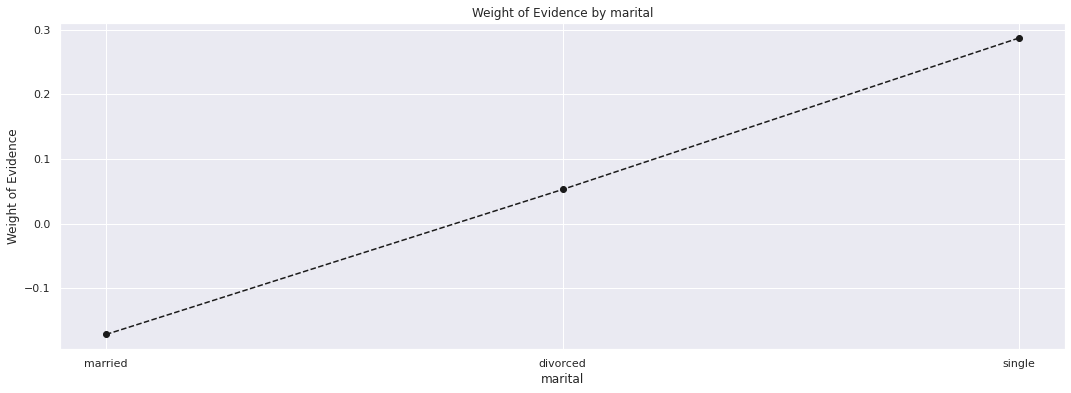

In [ ]:
plot_by_woe(df_temp)

In [ ]:
df_temp = woe_discrete(train_dummy, train_cat.columns[2], y_train)
df_temp

,education,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,primary,5531,0.086241,0.159459,477.0,5054.0,0.118216,0.164889,-0.332760,NaN,NaN,0.04783
1,secondary,18561,0.106729,0.535115,1981.0,16580.0,0.490954,0.540929,-0.096936,0.020488,0.235823,0.04783
2,tertiary,10594,0.148858,0.305426,1577.0,9017.0,0.390830,0.294183,0.284072,0.042129,0.381008,0.04783


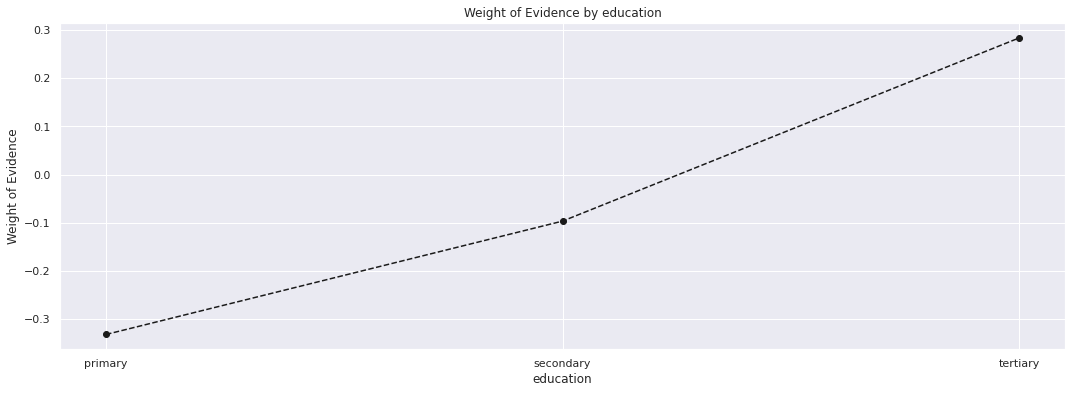

In [ ]:
plot_by_woe(df_temp)

In [ ]:
df_temp = woe_discrete(train_dummy, train_cat.columns[4], y_train)
df_temp

,housing,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,yes,20182,0.077098,0.558007,1556.0,18626.0,0.367762,0.583211,-0.461113,NaN,NaN,0.189121
1,no,15986,0.167334,0.441993,2675.0,13311.0,0.632238,0.416789,0.416685,0.090236,0.877799,0.189121


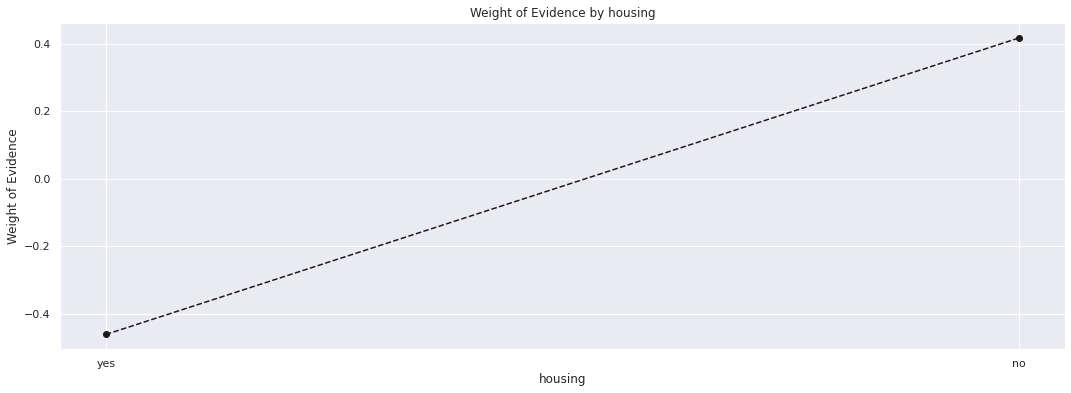

In [ ]:
plot_by_woe(df_temp)

In [ ]:
df_temp = woe_discrete(train_dummy, train_cat.columns[5], y_train)
df_temp

,loan,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,yes,5813,0.068123,0.160722,396.0,5417.0,0.093595,0.169615,-0.594556,NaN,NaN,0.051858
1,no,30355,0.126338,0.839278,3835.0,26520.0,0.906405,0.830385,0.087597,0.058215,0.682153,0.051858


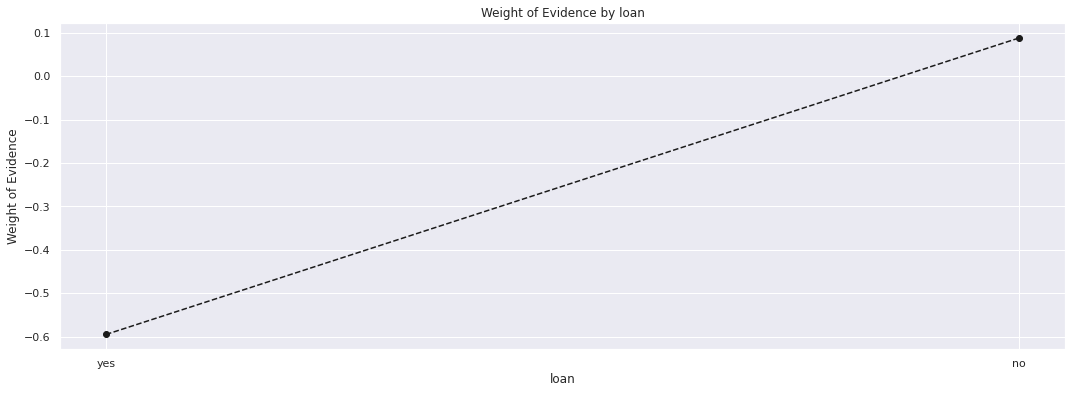

In [ ]:
plot_by_woe(df_temp)

In [ ]:
df_temp = woe_discrete(train_dummy, train_cat.columns[7], y_train)
df_temp

,month,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,may,11062,0.066805,0.305850,739.0,10323.0,0.174663,0.323230,-0.615505,NaN,NaN,0.429689
1,jul,5537,0.092649,0.153091,513.0,5024.0,0.121248,0.157310,-0.260379,0.025844,0.355126,0.429689
2,nov,3143,0.100541,0.086900,316.0,2827.0,0.074687,0.088518,-0.169902,0.007891,0.090477,0.429689
3,jan,1119,0.101877,0.030939,114.0,1005.0,0.026944,0.031468,-0.155218,0.001336,0.014685,0.429689
4,jun,4237,0.104083,0.117148,441.0,3796.0,0.104231,0.118859,-0.131331,0.002206,0.023886,0.429689
5,aug,4986,0.109306,0.137857,545.0,4441.0,0.128811,0.139055,-0.076522,0.005223,0.054809,0.429689
6,feb,2078,0.167950,0.057454,349.0,1729.0,0.082486,0.054138,0.421100,0.058644,0.497622,0.429689
7,apr,2394,0.195489,0.066191,468.0,1926.0,0.110612,0.060306,0.606595,0.027539,0.185494,0.429689
8,oct,592,0.437500,0.016368,259.0,333.0,0.061215,0.010427,1.770012,0.242011,1.163418,0.429689
9,sep,451,0.452328,0.012470,204.0,247.0,0.048216,0.007734,1.830058,0.014828,0.060046,0.429689


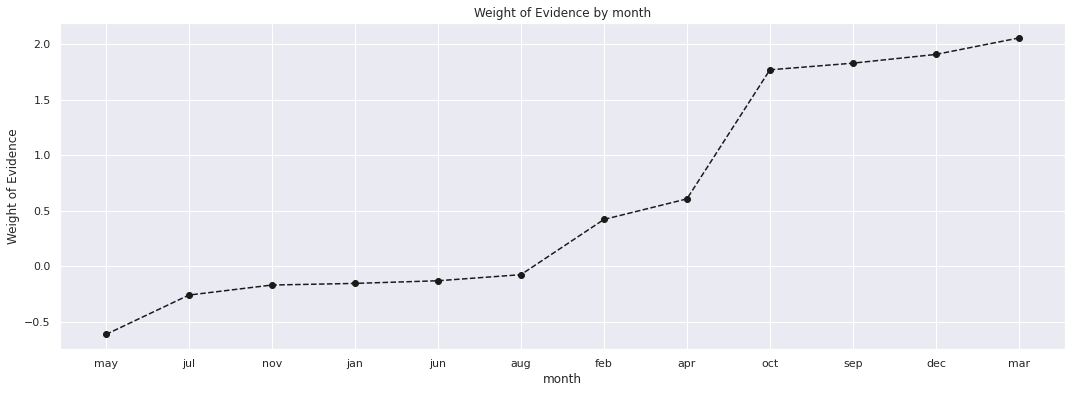

In [ ]:
plot_by_woe(df_temp)

In [ ]:
df_temp = woe_discrete(train_dummy, train_cat.columns[8], y_train)
df_temp

,poutcome,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,failure,3889,0.122911,0.591123,478.0,3411.0,0.318242,0.671853,-0.747227,NaN,NaN,1.088842
1,other,1485,0.164983,0.225718,245.0,1240.0,0.163116,0.244239,-0.403685,0.042072,0.343542,1.088842
2,success,1205,0.646473,0.183159,779.0,426.0,0.518642,0.083908,1.821495,0.481490,2.225180,1.088842


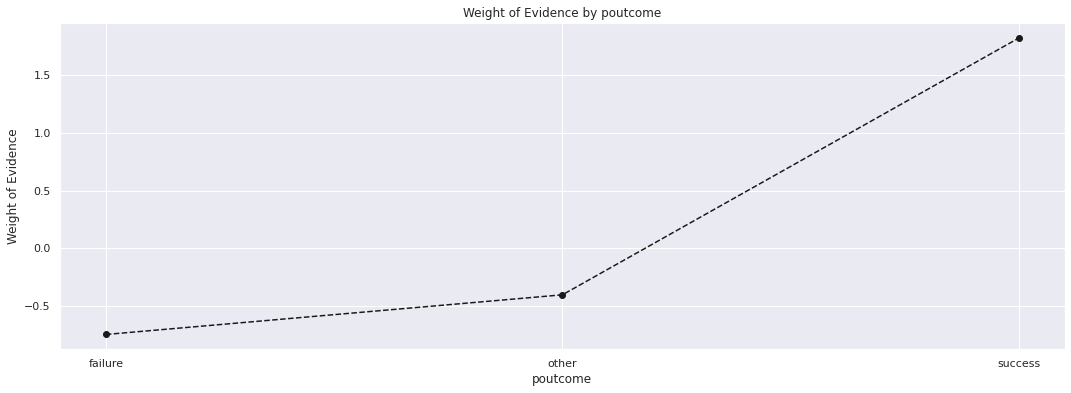

In [ ]:
plot_by_woe(df_temp)

Success of failure of the previous contact is by far the strongest univariate categorical predictive feature. Its IV is higher than recommended, but we'll keep it for now.

We would've gotten pretty similar picture if had simply analysed percent of the successful contacts per different categorical groups of clients

In [ ]:
suc_values = {}

for col in data.columns[:-1]:
  if data[col].dtype=='object':
    print(data.groupby(col).mean()['y'].sort_values())
    suc_values[col] = data.groupby(col).mean()['y'].sort_values().index[-1]
    

job
blue-collar      0.072750
entrepreneur     0.082717
housemaid        0.087903
services         0.088830
technician       0.110570
self-employed    0.118429
admin.           0.122027
management       0.137556
unemployed       0.155027
retired          0.227915
student          0.286780
Name: y, dtype: float64
marital
married     0.101235
divorced    0.119455
single      0.149492
Name: y, dtype: float64
education
primary      0.086265
secondary    0.105594
tertiary     0.150064
Name: y, dtype: float64
default
yes    0.063804
no     0.117961
Name: y, dtype: float64
housing
yes    0.077000
no     0.167024
Name: y, dtype: float64
loan
yes    0.066814
no     0.126557
Name: y, dtype: float64
contact
telephone    0.134205
cellular     0.149189
Name: y, dtype: float64
month
may    0.067195
jul    0.090935
jan    0.101212
nov    0.101511
jun    0.102228
aug    0.110133
feb    0.166478
apr    0.196794
oct    0.437669
sep    0.464594
dec    0.467290
mar    0.519916
Name: y, dtype: float64
pout

Print out the most benefitial categorical feature values

In [ ]:
suc_values

{'contact': 'cellular',
 'default': 'no',
 'education': 'tertiary',
 'housing': 'no',
 'job': 'student',
 'loan': 'no',
 'marital': 'single',
 'month': 'mar',
 'poutcome': 'success'}

Judging by categorical features only, the campaign's perfect client is a single student w/ no loans or credit default, having tertiary education and a history of previous succesful campaign engagements. He was riched wia cell phone in March.

In [ ]:
for col in list(suc_values.items()):
  data = data[data[col[0]]==col[1]]

In [ ]:
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
43221,26,student,single,tertiary,no,294,no,no,cellular,5,mar,87,1,91,2,success,1


It is still more correct to use WoE approach though.

Now let's deal w/ numerical features

In [ ]:
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [ ]:
train_dummy_c = train_dummy.copy()

In [ ]:
# fine-classing using the 'cut' method, given the large number of unique values
train_dummy_c['pdays'] = pd.cut(train_dummy['pdays'], 10)
# Process 'int_rate_factor' column through woe_ordered_continuous and plot_by_woe functions
df_temp = woe_ordered_continuous(train_dummy_c, 'pdays', y_train)
df_temp

,pdays,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(0.001, 100.9]",1155,0.436364,0.031934,504.0,651.0,0.119121,0.020384,1.765393,NaN,NaN,0.348524
1,"(100.9, 200.8]",2256,0.253546,0.062376,572.0,1684.0,0.135193,0.052729,0.941539,0.182818,0.823855,0.348524
2,"(200.8, 300.7]",1186,0.129848,0.032791,154.0,1032.0,0.036398,0.032314,0.119025,0.123698,0.822513,0.348524
3,"(300.7, 400.6]",1798,0.098999,0.049712,178.0,1620.0,0.042070,0.050725,-0.187071,0.030849,0.306097,0.348524
4,"(400.6, 500.5]",110,0.563636,0.003041,62.0,48.0,0.014654,0.001503,2.277260,0.464637,2.464331,0.348524
5,"(500.5, 600.4]",36,0.500000,0.000995,18.0,18.0,0.004254,0.000564,2.021327,0.063636,0.255933,0.348524
6,"(600.4, 700.3]",17,0.352941,0.000470,6.0,11.0,0.001418,0.000344,1.415191,0.147059,0.606136,0.348524
7,"(700.3, 800.2]",17,0.294118,0.000470,5.0,12.0,0.001182,0.000376,1.145858,0.058824,0.269333,0.348524
8,"(800.2, 900.1]",9,0.555556,0.000249,5.0,4.0,0.001182,0.000125,2.244470,0.261438,1.098612,0.348524
9,"(900.1, 1000.0]",29584,0.092178,0.817961,2727.0,26857.0,0.644528,0.840937,-0.265998,0.463377,2.510468,0.348524


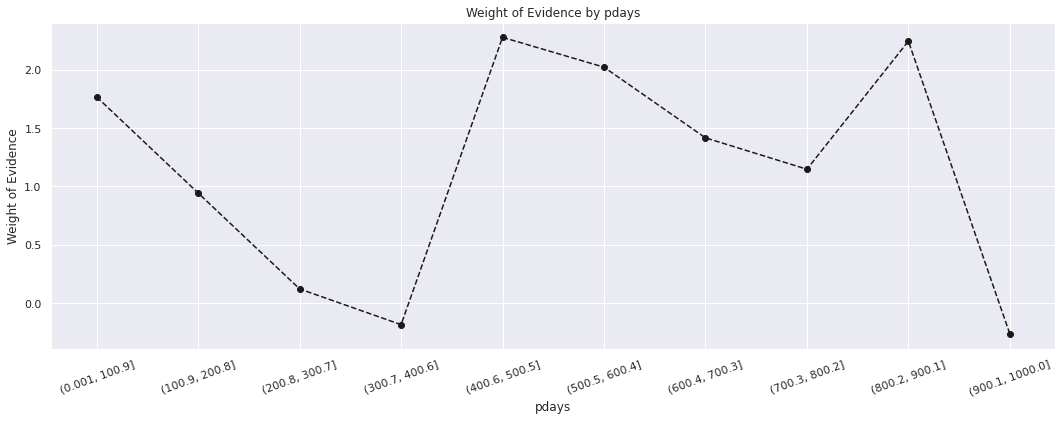

In [ ]:
plot_by_woe(df_temp, 20)

In [ ]:
X_train.campaign.max()

63

In [ ]:
# fine-classing using the 'cut' method, given the large number of unique values
train_temp = train_dummy[train_dummy['campaign'] <= 17].copy()
train_dummy_c['campaign'] = pd.cut(train_temp['campaign'], 17)
# Process 'int_rate_factor' column through woe_ordered_continuous and plot_by_woe functions
df_temp = woe_ordered_continuous(train_dummy_c, 'campaign', y_train[train_dummy_c.index])
df_temp

,campaign,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(0.984, 1.941]",14026,0.145872,0.391099,2046.0,11980.0,0.484146,0.378671,0.245719,NaN,NaN,0.078727
1,"(1.941, 2.882]",10023,0.111543,0.279480,1118.0,8905.0,0.264553,0.281474,-0.062000,0.034329,0.307720,0.078727
2,"(2.882, 3.824]",4412,0.112647,0.123024,497.0,3915.0,0.117605,0.123748,-0.050909,0.001104,0.011091,0.078727
3,"(3.824, 4.765]",2805,0.089840,0.078214,252.0,2553.0,0.059631,0.080697,-0.302524,0.022808,0.251615,0.078727
4,"(4.765, 5.706]",1419,0.080338,0.039567,114.0,1305.0,0.026976,0.041249,-0.424688,0.009501,0.122165,0.078727
5,"(5.706, 6.647]",1018,0.072692,0.028386,74.0,944.0,0.017511,0.029838,-0.532990,0.007647,0.108301,0.078727
6,"(6.647, 7.588]",596,0.065436,0.016619,39.0,557.0,0.009229,0.017606,-0.645932,0.007255,0.112943,0.078727
7,"(7.588, 8.529]",456,0.052632,0.012715,24.0,432.0,0.005679,0.013655,-0.877300,0.012805,0.231368,0.078727
8,"(8.529, 9.471]",251,0.067729,0.006999,17.0,234.0,0.004023,0.007396,-0.609036,0.015098,0.268264,0.078727
9,"(9.471, 10.412]",217,0.050691,0.006051,11.0,206.0,0.002603,0.006511,-0.916909,0.017038,0.307873,0.078727


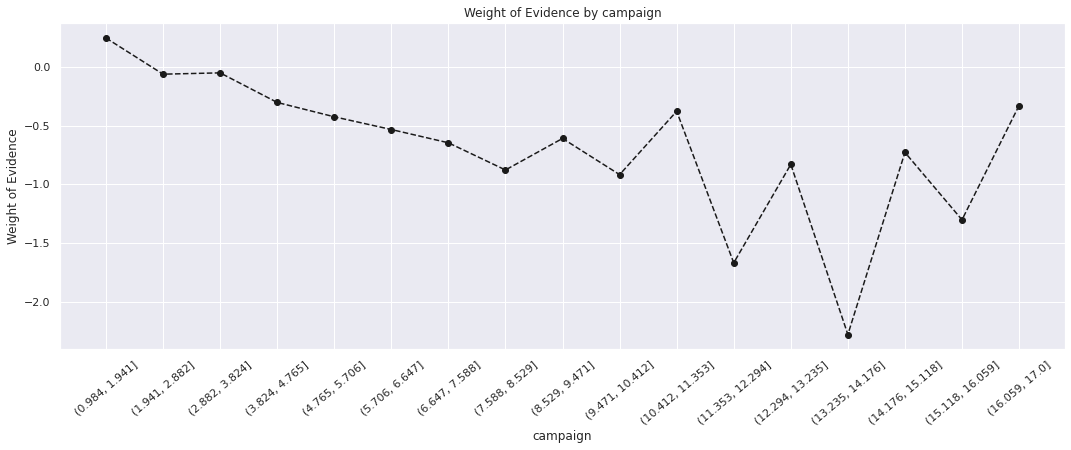

In [ ]:
plot_by_woe(df_temp, 40)

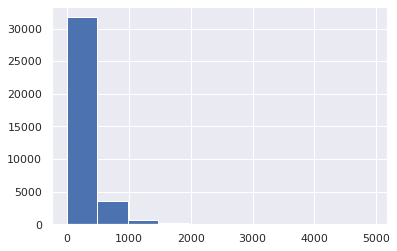

In [ ]:
train_dummy.duration.hist()

In [ ]:
# fine-classing using the 'cut' method, given the large number of unique values
train_temp = train_dummy[train_dummy['duration'] <= 1500].copy()
train_dummy_c['duration'] = pd.cut(train_temp['duration'], 50)
# Process 'int_rate_factor' column through woe_ordered_continuous and plot_by_woe functions
df_temp = woe_ordered_continuous(train_dummy_c, 'duration',y_train[train_dummy_c.index])
df_temp

,duration,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-1.5, 30.0]",1599,0.001876,0.044435,3.0,1596.0,0.000729,0.050082,-4.230166,NaN,NaN,1.663435
1,"(30.0, 60.0]",2221,0.001351,0.061720,3.0,2218.0,0.000729,0.069600,-4.559271,0.000525,0.329105,1.663435
2,"(60.0, 90.0]",3619,0.013816,0.100570,50.0,3569.0,0.012145,0.111993,-2.221540,0.012465,2.337731,1.663435
3,"(90.0, 120.0]",3775,0.030464,0.104905,115.0,3660.0,0.027933,0.114849,-1.413809,0.016648,0.807731,1.663435
4,"(120.0, 150.0]",3642,0.050247,0.101209,183.0,3459.0,0.044450,0.108541,-0.892771,0.019784,0.521038,1.663435
5,"(150.0, 180.0]",3253,0.067015,0.090399,218.0,3035.0,0.052951,0.095237,-0.586994,0.016768,0.305777,1.663435
6,"(180.0, 210.0]",2615,0.082218,0.072669,215.0,2400.0,0.052222,0.075311,-0.366108,0.015203,0.220886,1.663435
7,"(210.0, 240.0]",2241,0.105310,0.062276,236.0,2005.0,0.057323,0.062916,-0.093090,0.023092,0.273018,1.663435
8,"(240.0, 270.0]",1928,0.132261,0.053578,255.0,1673.0,0.061938,0.052498,0.165367,0.026951,0.258457,1.663435
9,"(270.0, 300.0]",1501,0.128581,0.041712,193.0,1308.0,0.046879,0.041044,0.132913,0.003680,0.032454,1.663435


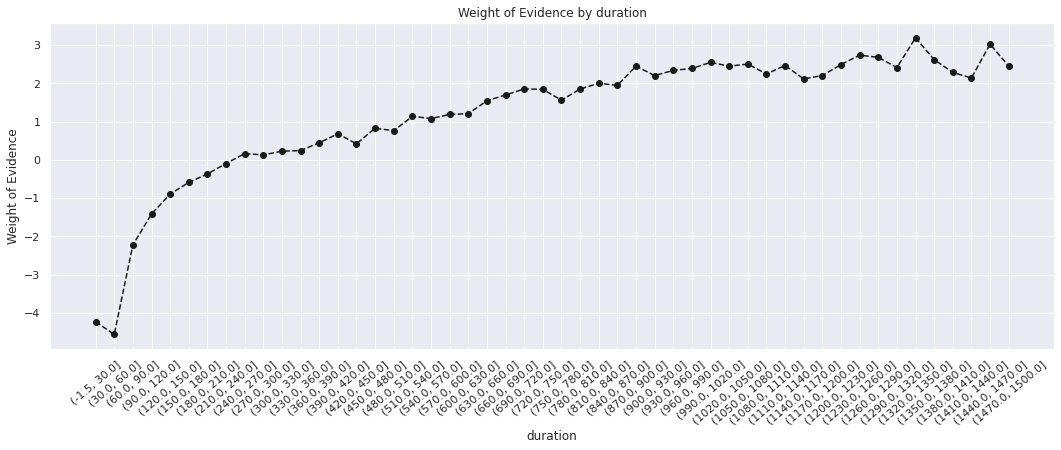

In [ ]:
plot_by_woe(df_temp, 40)

Abnormally high IV, however, dropping this feature would result in significantly worse predictions during CV and on the test set.

In [ ]:
train_dummy.previous.min(), train_dummy.previous.max()

(0, 275)

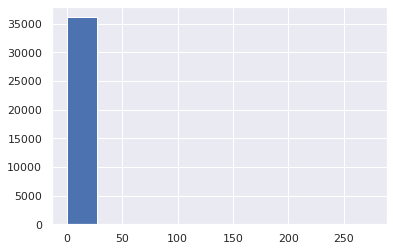

In [ ]:
train_dummy.previous.hist()

In [ ]:
# fine-classing using the 'cut' method, given the large number of unique values
train_temp = train_dummy[train_dummy['previous'] <=15].copy()
train_dummy_c['previous'] = pd.cut(train_temp['previous'], 15)
# Process 'int_rate_factor' column through woe_ordered_continuous and plot_by_woe functions
df_temp = woe_ordered_continuous(train_dummy_c, 'previous', y_train[train_dummy_c.index])
df_temp

,previous,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.015, 1.0]",31816,0.100201,0.881843,3188.0,28628.0,0.755450,0.898584,-0.173507,NaN,NaN,0.157431
1,"(1.0, 2.0]",1681,0.210589,0.046592,354.0,1327.0,0.083886,0.041652,0.700106,0.110388,0.873612,0.157431
2,"(2.0, 3.0]",881,0.256527,0.024419,226.0,655.0,0.053555,0.020559,0.957385,0.045938,0.257279,0.157431
3,"(3.0, 4.0]",563,0.241563,0.015605,136.0,427.0,0.032227,0.013403,0.877356,0.014964,0.080029,0.157431
4,"(4.0, 5.0]",368,0.271739,0.010200,100.0,268.0,0.023697,0.008412,1.035668,0.030176,0.158312,0.157431
5,"(5.0, 6.0]",228,0.315789,0.006319,72.0,156.0,0.017062,0.004897,1.248295,0.044050,0.212627,0.157431
6,"(6.0, 7.0]",157,0.242038,0.004352,38.0,119.0,0.009005,0.003735,0.879947,0.073751,0.368347,0.157431
7,"(7.0, 8.0]",107,0.299065,0.002966,32.0,75.0,0.007583,0.002354,1.169733,0.057027,0.289785,0.157431
8,"(8.0, 9.0]",71,0.239437,0.001968,17.0,54.0,0.004028,0.001695,0.865714,0.059629,0.304018,0.157431
9,"(9.0, 10.0]",56,0.392857,0.001552,22.0,34.0,0.005213,0.001067,1.586167,0.153421,0.720453,0.157431


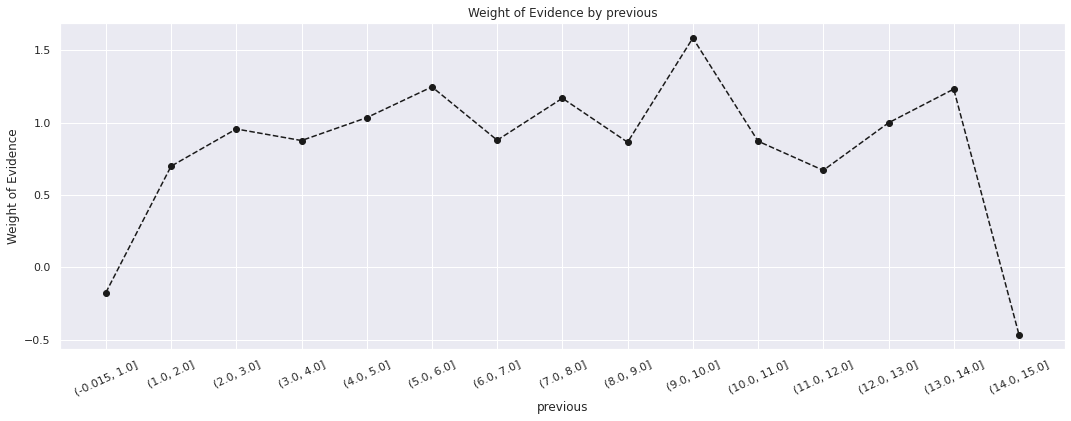

In [ ]:
plot_by_woe(df_temp, 25)

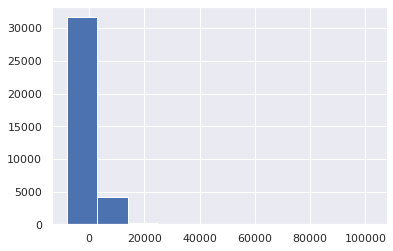

In [ ]:
train_dummy.balance.hist()

In [ ]:
# fine-classing using the 'cut' method, given the large number of unique values
train_temp = train_dummy[train_dummy['balance'].isin(range(13000))].copy()
train_dummy_c['balance'] = pd.cut(train_temp['balance'], 50)
# Process 'int_rate_factor' column through woe_ordered_continuous and plot_by_woe functions
df_temp = woe_ordered_continuous(train_dummy_c, 'balance', y_train[train_dummy_c.index])
df_temp

,balance,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-12.972, 259.44]",11132,0.091538,0.339525,1019.0,10113.0,0.253294,0.351585,-0.327903,NaN,NaN,0.089684
1,"(259.44, 518.88]",5039,0.116491,0.153689,587.0,4452.0,0.145911,0.154777,-0.058987,0.024953,0.268916,0.089684
2,"(518.88, 778.32]",3312,0.118357,0.101016,392.0,2920.0,0.097440,0.101516,-0.040980,0.001866,0.018007,0.089684
3,"(778.32, 1037.76]",2220,0.138288,0.067710,307.0,1913.0,0.076311,0.066507,0.137516,0.019931,0.178497,0.089684
4,"(1037.76, 1297.2]",1647,0.129933,0.050233,214.0,1433.0,0.053194,0.049819,0.065547,0.008355,0.071969,0.089684
5,"(1297.2, 1556.64]",1363,0.126192,0.041571,172.0,1191.0,0.042754,0.041406,0.032043,0.003741,0.033505,0.089684
6,"(1556.64, 1816.08]",1052,0.154943,0.032086,163.0,889.0,0.040517,0.030907,0.270750,0.028751,0.238707,0.089684
7,"(1816.08, 2075.52]",813,0.136531,0.024796,111.0,702.0,0.027591,0.024406,0.122694,0.018412,0.148056,0.089684
8,"(2075.52, 2334.96]",696,0.147989,0.021228,103.0,593.0,0.025603,0.020616,0.216631,0.011457,0.093938,0.089684
9,"(2334.96, 2594.4]",621,0.183575,0.018940,114.0,507.0,0.028337,0.017626,0.474784,0.035586,0.258153,0.089684


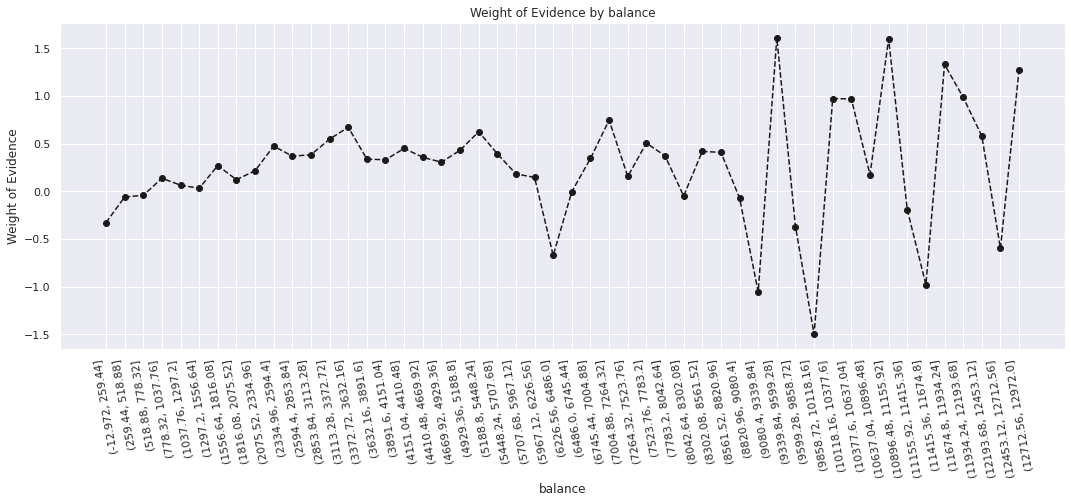

In [ ]:
plot_by_woe(df_temp,100)

Now, as we intend to analyze marketing campaign success through the internals of ML model it is acceptable to sacrifice some accuracy in favor of interpritability. To do that we can try to fit logistic regression on the binned features - this way we estimate both amount and direction of influence of the given bin on the outcome of the contact, e.g. how much belonging to the 30-40 age group influences the chances of subscribing to the product.

Unlike simple WoE/IV estimation, logistic regression coefficients describe how certain feature values influence the outcome given other features' values throughout training history. Being learned as a result of fitting on whole dataset, model's weights encapsulate not independent features influence but rather conditional one.

One thing to keep in mind is that in order to avoid multicollinearity we are dropping one of the bins for every feature, thus losing ability to determine this bin's influence on a target variable.

Let's create proper features bins based on conducted WoE and IV analysis.

In [ ]:
train_dummy = dummy_creation(X_train.drop(['age', 'default', 'contact', 'day'], axis=1), chi2_result.Feature[:7])

In [ ]:
train_dummy

,job,marital,education,balance,housing,loan,month,duration,campaign,pdays,previous,poutcome,job:admin.,job:blue-collar,job:entrepreneur,job:housemaid,job:management,job:retired,job:self-employed,job:services,job:student,job:technician,job:unemployed,marital:divorced,marital:married,marital:single,education:primary,education:secondary,education:tertiary,housing:no,housing:yes,loan:no,loan:yes,month:apr,month:aug,month:dec,month:feb,month:jan,month:jul,month:jun,month:mar,month:may,month:nov,month:oct,month:sep,poutcome:failure,poutcome:other,poutcome:success
24001,technician,divorced,secondary,861,no,no,aug,140,2,1000,0,NaN,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
43409,student,single,secondary,4126,no,no,apr,907,4,185,7,failure,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
20669,technician,single,secondary,244,yes,no,aug,1735,4,1000,0,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
18810,unemployed,married,secondary,0,no,no,jul,35,11,1000,0,NaN,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
23130,technician,married,secondary,257,no,no,aug,57,10,1000,0,NaN,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17958,blue-collar,married,secondary,917,yes,no,jul,58,2,1000,0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
15941,admin.,single,secondary,22,yes,no,jul,77,5,1000,0,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
16952,blue-collar,married,secondary,79,yes,no,jul,98,1,1000,0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
34781,management,single,tertiary,2559,yes,no,may,227,1,1000,0,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
train_dummy.isnull().sum()

job                      234
marital                    0
education               1482
balance                    0
housing                    0
loan                       0
month                      0
duration                   0
campaign                   0
pdays                      0
previous                   0
poutcome               29589
job:admin.                 0
job:blue-collar            0
job:entrepreneur           0
job:housemaid              0
job:management             0
job:retired                0
job:self-employed          0
job:services               0
job:student                0
job:technician             0
job:unemployed             0
marital:divorced           0
marital:married            0
marital:single             0
education:primary          0
education:secondary        0
education:tertiary         0
housing:no                 0
housing:yes                0
loan:no                    0
loan:yes                   0
month:apr                  0
month:aug     

In [ ]:
ref_categories = ['job:tech_self_admin', 'marital:single','education:tertiary',
                  'housing:no','loan:no', 'poutcome:oth_fail', 'pdays:>800.2',
                  'campaign:>18', 'duration:>1500', 'previous:>15', 'balance:>13000',
                  'month:5']

In [ ]:
# This custom class will create new categorical dummy features based on the cut-off points that we manually identified
# based on the WoE plots and IV above.
# Given the way it is structured, this class also allows a fit_transform method to be implemented on it, thereby allowing 
# us to use it as part of a scikit-learn Pipeline 
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
        
    def fit(self, X, y = None):
        
        return self #nothing else to do
    def transform(self, X):
        #categorical
        X_new = pd.DataFrame()
        X_new['job:blue-collar'] = X.loc[:,'job:blue-collar']
        X_new['job:management'] = X.loc[:,'job:management']
        X_new['job:retired'] = X.loc[:,'job:retired']
        X_new['job:student'] = X.loc[:,'job:student']
        X_new['job:unemployed'] = X.loc[:,'job:unemployed']
        X_new['job:ent_ser_hous'] = sum([X['job:entrepreneur'], X['job:services'], X['job:housemaid']])
        X_new['job:tech_self_admin'] = sum([X['job:technician'], X['job:self-employed'], X['job:admin.']])
        X_new['job:missing'] = np.where(X['job'].isnull(), 1, 0)

        X_new = pd.concat([X_new, X.loc[:, 'marital:divorced':'marital:single']], axis = 1)

        X_new = pd.concat([X_new, X.loc[:, 'education:primary':'education:tertiary']], axis = 1)
        X_new['education:missing'] = np.where(X['education'].isnull(), 1, 0)

        X_new = pd.concat([X_new, X.loc[:, 'housing:no':'housing:yes']], axis = 1)

        X_new = pd.concat([X_new, X.loc[:, 'loan:no':'loan:yes']], axis = 1)

        X_new['poutcome:success'] = X.loc[:,'poutcome:success']
        X_new['poutcome:oth_fail'] = sum([X['poutcome:other'], X['poutcome:failure']])
        X_new['poutcome:missing'] = np.where(X['poutcome'].isnull(), 1, 0)

        X_new['month:5'] = X.loc[:,'month:may']
        X_new['month:1,6,7,8,11'] = sum([X['month:jan'], X['month:jun'], X['month:jul'],
                                         X['month:aug'], X['month:nov']])
        X_new['month:3,9,10,12'] = sum([X['month:mar'], X['month:sep'], X['month:oct'],
                                         X['month:dec']])
        X_new['month:2,4'] = sum([X['month:feb'], X['month:apr']])
        
        
        #numerical
        
        X_new['pdays:<300.7'] = np.where((X['pdays'] <= 300.7), 1, 0)
        X_new['pdays:300.7-400.6'] = np.where((X['pdays'] > 300.7) & (X['pdays'] <= 400.6), 1, 0)
        X_new['pdays:400.6-800.2'] = np.where((X['pdays'] > 400.6) & (X['pdays'] <= 800.2), 1, 0)
        X_new['pdays:>800.2'] = np.where((X['pdays'] > 800.2), 1, 0)

        X_new['campaign:<1.941'] = np.where((X['campaign'] <= 1.941) & (X['campaign'] <=1.941), 1, 0)
        X_new['campaign:1.941-3.824'] = np.where((X['campaign'] > 1.941) & (X['campaign'] <=3.824), 1, 0)
        X_new['campaign:3.824-4.765'] = np.where((X['campaign'] > 3.824) & (X['campaign'] <=4.765), 1, 0)
        X_new['campaign:4.765-6.647'] = np.where((X['campaign'] > 4.765) & (X['campaign'] <=6.647), 1, 0)
        X_new['campaign:6.647-9.471'] = np.where((X['campaign'] > 6.647) & (X['campaign'] <=9.471), 1, 0)
        X_new['campaign:9.471-17'] = np.where((X['campaign'] > 9.471) & (X['campaign'] <=17), 1, 0)
        X_new['campaign:>18'] = np.where((X['campaign'] > 17), 1, 0)
        
        X_new['duration:<90'] = np.where((X['duration'] <= 90), 1, 0)
        X_new['duration:90-270'] = np.where((X['duration'] > 90) & (X['duration'] <=270), 1, 0)
        X_new['duration:270-510'] = np.where((X['duration'] > 270) & (X['duration'] <=510), 1, 0)
        X_new['duration:510-780'] = np.where((X['duration'] > 510) & (X['duration'] <=780), 1, 0)
        X_new['duration:780-1020'] = np.where((X['duration'] > 780) & (X['duration'] <=1020), 1, 0)
        X_new['duration:1020-1500'] = np.where((X['duration'] > 1020) & (X['duration'] <=1500), 1, 0)
        X_new['duration:>1500'] = np.where((X['duration'] > 1500), 1, 0)

        X_new['previous:<1'] = np.where((X['previous'] <= 1), 1, 0)
        X_new['previous:1-5'] = np.where((X['previous'] > 1) & (X['previous'] <=5), 1, 0)
        X_new['previous:5-9'] = np.where((X['previous'] > 5) & (X['previous'] <=9), 1, 0)
        X_new['previous:9-10'] = np.where((X['previous'] > 9) & (X['previous'] <=10), 1, 0)
        X_new['previous:10-11'] = np.where((X['previous'] > 10) & (X['previous'] <=11), 1, 0)
        X_new['previous:11-14'] = np.where((X['previous'] > 11) & (X['previous'] <=14), 1, 0)
        X_new['previous:14-15'] = np.where((X['previous'] > 14) & (X['previous'] <=15), 1, 0)
        X_new['previous:>15'] = np.where((X['previous'] > 15), 1, 0)

        X_new['balance:<259.6'] = np.where((X['balance'] <= 259.6), 1, 0)
        X_new['balance:259.6-2855.6'] = np.where((X['balance'] > 259.6) & (X['balance'] <= 2855.6), 1, 0)
        X_new['balance:2855.6-4153.6'] = np.where((X['balance'] > 2855.6) & (X['balance'] <= 4153.6), 1, 0)
        X_new['balance:4153.6-5711.2'] = np.where((X['balance'] > 4153.6) & (X['balance'] <= 5711.2), 1, 0)
        X_new['balance:5711.2-9086.0'] = np.where((X['balance'] > 5711.2) & (X['balance'] <= 9086.0), 1, 0)
        X_new['balance:9086.0-13000'] = np.where((X['balance'] > 9086.0) & (X['balance'] <= 13000), 1, 0)
        X_new['balance:>13000'] = np.where((X['balance'] > 13000), 1, 0)

    
        X_new.drop(columns = ref_categories, inplace = True)

        return X_new


In [ ]:
# define modeling pipeline, balanced class weight for imbalanced dataset
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(train_dummy)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

In [ ]:
len(train_dummy), len(y_train)

(36168, 36168)

In [ ]:
# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, train_dummy, y_train, scoring = 'roc_auc', cv = cv)
scores1 = cross_val_score(pipeline, train_dummy, y_train, scoring = 'accuracy', cv = cv)
AUROC = np.mean(scores)
ACCURACY = np.mean(scores1)

# print the mean AUROC score and accuracy
print('Mean AUROC: %.4f' % (AUROC))
print('Mean ACCURACY: %.4f' % (ACCURACY))

Mean AUROC: 0.9005
Mean ACCURACY: 0.8323


Note that accuracy score is almost useless in our case as with highly imbalanced dataset (~11% negative samples) naive classifier can reach ~89% accuracy.

In [ ]:
pipeline.fit(train_dummy, y_train)

Pipeline(memory=None,
         steps=[('woe',
                 WoE_Binning(X=               job   marital  ... poutcome:other  poutcome:success
24001   technician  divorced  ...              0                 0
43409      student    single  ...              0                 0
20669   technician    single  ...              0                 0
18810   unemployed   married  ...              0                 0
23130   technician   married  ...              0                 0
...            ...       ...  ...            ...               ...
17958  blue-collar   married  ...              0                 0
15941       admin.    single  ...              0                 0
16952  blue-collar   married  ...              0                 0
34781   management    single  ...              0                 0
44229       admin.   married  ...              0                 0

[36168 rows x 48 columns])),
                ('model',
                 LogisticRegression(C=1.0, class_weight='balanc

In [ ]:
test_dummy = dummy_creation(X_test.drop(['age', 'default', 'contact', 'day'], axis=1), chi2_result.Feature[:7])
test_dummy = test_dummy.reindex(labels=train_dummy.columns, axis=1, fill_value=0)

In [ ]:
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_transform.fit_transform(train_dummy)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,3.683509
1,job:blue-collar,-0.233471
2,job:management,0.003400
3,job:retired,0.509445
4,job:student,0.812104
5,job:unemployed,-0.169257
6,job:ent_ser_hous,-0.168212
7,job:missing,-0.389662
8,marital:divorced,-0.172108
9,marital:married,-0.386251


Let's visualise results

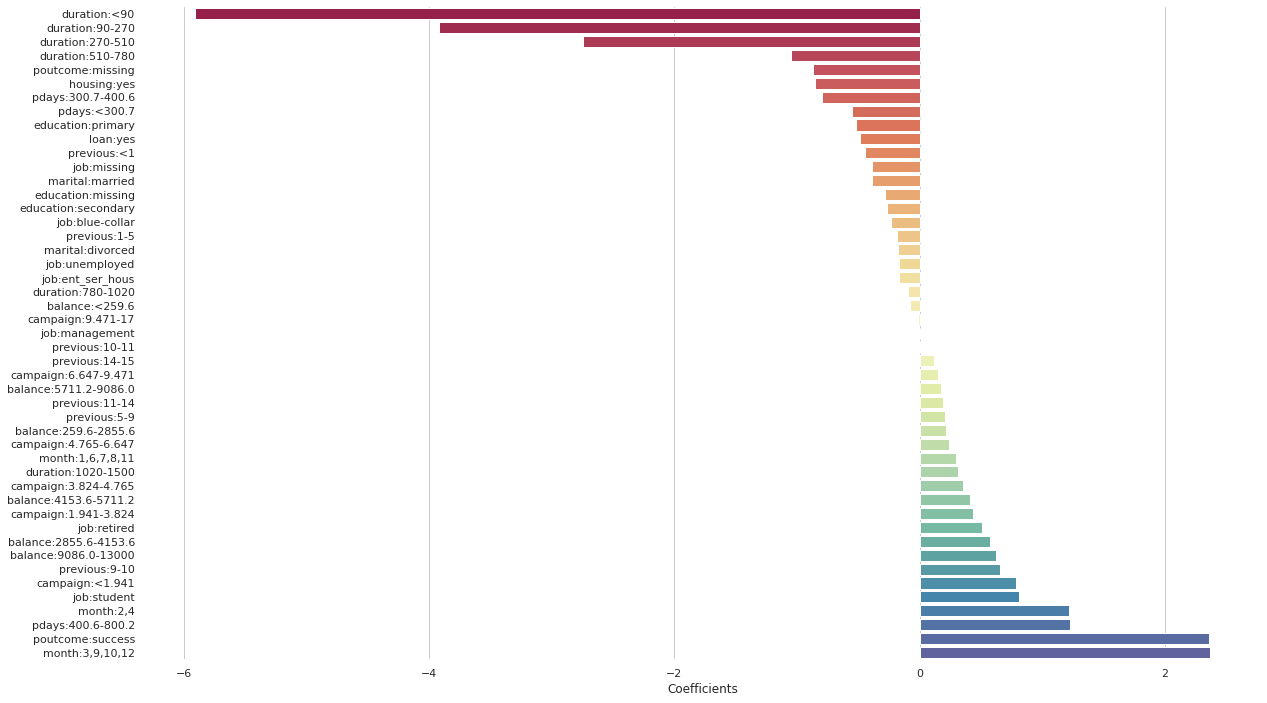

In [ ]:
sns.set(style='whitegrid')
sns.set_color_codes('muted')


f, ax = plt.subplots(figsize=(20, 12))

sns_t= sns.barplot(x='Coefficients', y='Feature name', 
                   data=summary_table[1:].sort_values('Coefficients'),
                   palette='Spectral')

ax.set(ylabel='', xlabel='Coefficients')

sns.despine(left=True, bottom=True)

We could use this graph in order to come up with better feature values when making contact with a client. 

For instance, previous successful outcome has great deal of influence, as well as contacting clients in certain months. However, one should not contact previously subscribed clients immediately after the last contact, as stated by pdays 400-800 bin influence and should not contact frequently as probability of success decreases as number of contacts within current campaign increases. Seems like the ones that were contacted often before current campaign (previous 9-10) but were barely reached during this one are the easiest to approach.

Contact duration seems to have negative correlation with the success, however, additional analysis is required in order to determine causal relationshhip here, as low duration might be both the reason for refusal (bank serviceman wasn't mentally invested in a conversation) and its consequence (some clients quickly deny the opportunity for different callers).

Students are still the most desired audience for campaign.

Knowing a year of the campaign would allow to investigate some additional relations - day of week, currency exchange rates or even the weather making impact on clients mood.

In [ ]:
# make preditions on our test set
y_hat_test = pipeline.predict(test_dummy)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(test_dummy)
# select the probabilities of only the positive class
y_hat_test_proba = y_hat_test_proba[:][: , 1]

In [ ]:
# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# check the shape to make sure the number of rows is same as that in y_test
y_test_proba.shape

(9043, 2)

In [ ]:
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = test_dummy.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba
1392,0,0.100127
7518,0,0.083739
12007,0,0.078812
5536,0,0.049291
29816,0,0.069443


In [ ]:
# assign a threshold value to differentiate good with bad
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.73570718, 0.14729625],
       [0.0224483 , 0.09454827]])

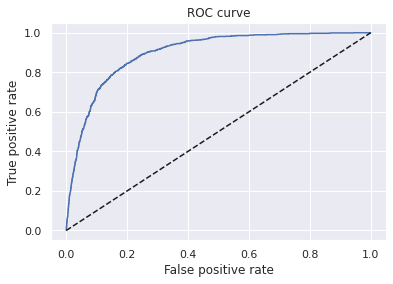

In [ ]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [ ]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC

0.8979823937368387

In [ ]:
#test accuracy
accuracy_score(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'])

0.8302554462014818

In [ ]:
#recall for positive labels (how much of successfull contacts we got right)
#baseline naive classifier (predicting most frequent class) would score 0 here
recall_score(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'])

0.8081285444234405

In [ ]:
#recall for negative labels (how much of unsuccessfull contacts we got right)
#baseline naive classifier would score 1 here
recall_score(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], pos_label=0)

0.8331872260488415

Note that we could search for better threshold using Youden’s J statistic and probably get better metrics results, but our aim was to analyze model's weights to determine conditional features influence. Besides, overall we got pretty good recall scores for highly imbalanced dataset.

# XGBoost+SHAP

Let's try different approach and use XGBoost with SHAP explainer

When using WoE we didn't take care of missing values, outliers and feature encoding as all that waas naturally handled by binning. XGBoost allows for missing values and outliers, so we won't deal with them here either (althoug one could employ KNN imputer for MV for example), but will look into feature encoding. We'll also create some additional features to see if it helps.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data.txt', sep="\t")

In [ ]:
def has_job(x):
  if x in ['uneployed', 'student', 'retired']: return 0
  elif x in ['management', 'technician', 'entrepreneur', 'blue-collar','admin.', 
              'services', 'self-employed',
      'housemaid']: return 1
  else: return x

In [ ]:
def get_season(x):
  if x in ['jan', 'feb', 'dec']: return 'winter'
  elif x in ['mar', 'apr', 'may']: return 'spring'
  elif x in ['jun', 'jul', 'aug']: return 'summer'
  else: return 'autumn'


In [ ]:
data['has job'] = data['job'].apply(lambda x: has_job(x))
data['was reached'] = data['pdays'].apply(lambda x: 1 if x!=-1 else 0)
data['season'] = data['month'].apply(lambda x: get_season(x))
data['has couple'] = data['marital'].apply(lambda x: 1 if x=='married' else 0)
data['y'] = data['y'].apply(lambda x: 1 if x=='yes' else 0)

In [ ]:
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,has job,was reached,season,has couple
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,1,0,spring,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,1,0,spring,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,1,0,spring,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0,1,0,spring,1
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0,unknown,0,spring,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1,1,0,autumn,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1,0,0,autumn,0
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1,0,1,autumn,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0,1,0,autumn,1


Let's have a look at how numerical data is distributed

{'boxes': [<matplotlib.lines.Line2D at 0x7fed4a950d90>],
 'caps': [<matplotlib.lines.Line2D at 0x7fed1ef8d310>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fed4a854690>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fed29aed2d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fed4a9501d0>,
  <matplotlib.lines.Line2D at 0x7fed4a950410>]}

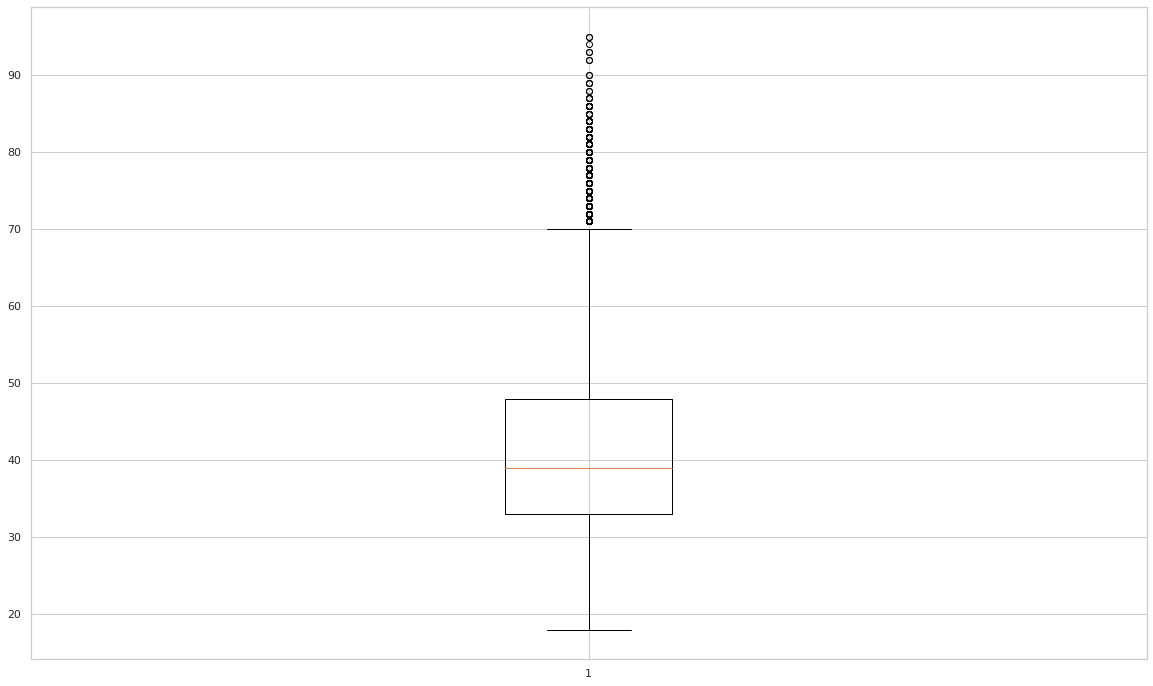

In [ ]:
f, ax = plt.subplots(figsize=(20, 12))
plt.boxplot(data.age)

{'boxes': [<matplotlib.lines.Line2D at 0x7fed2f534290>],
 'caps': [<matplotlib.lines.Line2D at 0x7fed2f552a10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fed4a9569d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fed4a956dd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fed282c62d0>,
  <matplotlib.lines.Line2D at 0x7fed2f552610>]}

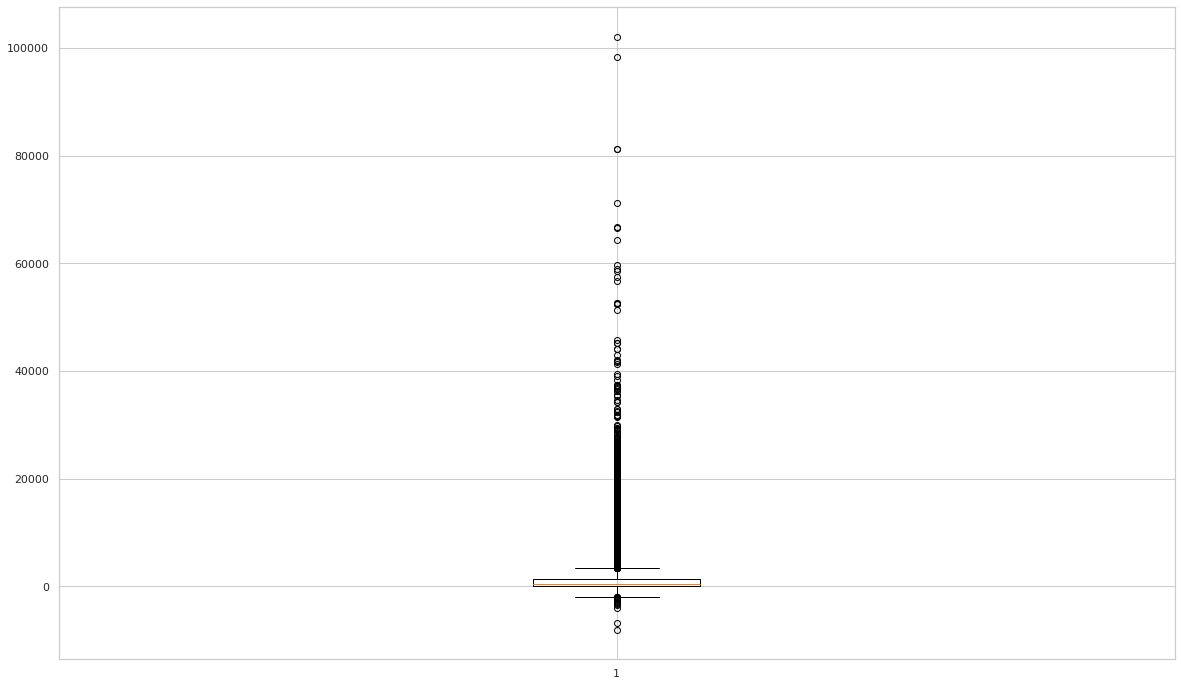

In [ ]:
f, ax = plt.subplots(figsize=(20, 12))
plt.boxplot(data.balance)

{'boxes': [<matplotlib.lines.Line2D at 0x7fed29b16f90>],
 'caps': [<matplotlib.lines.Line2D at 0x7fed1f44b1d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fed2825a550>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fed2825aa10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fed1f44b6d0>,
  <matplotlib.lines.Line2D at 0x7fed1f44b210>]}

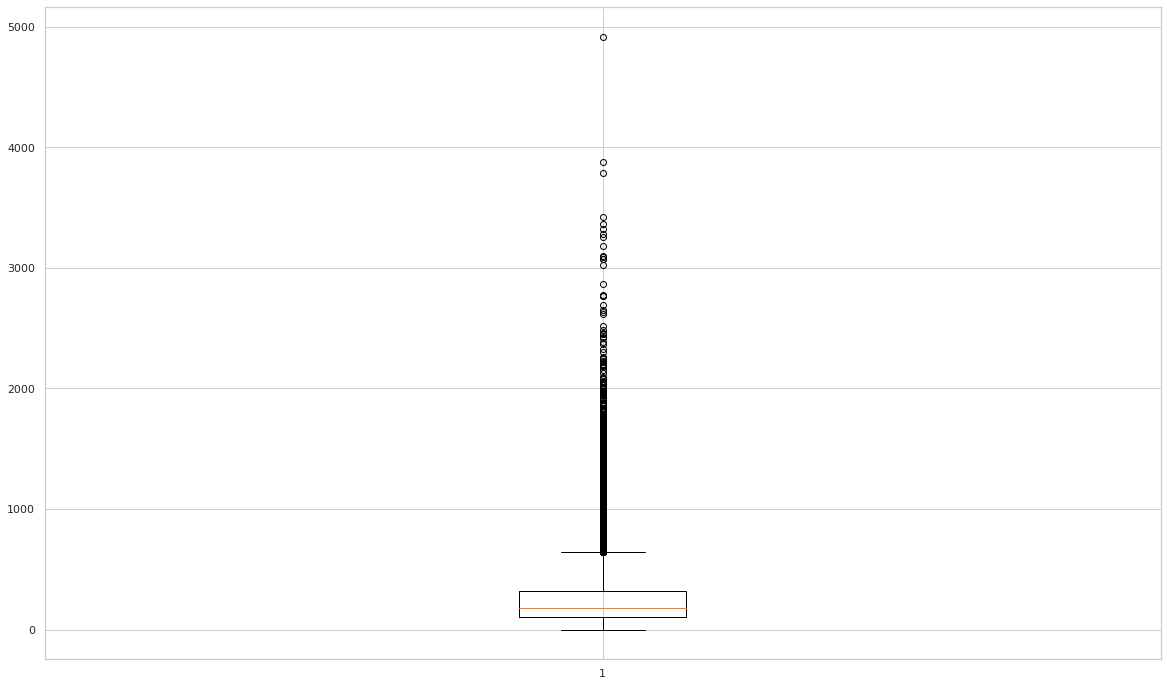

In [ ]:
f, ax = plt.subplots(figsize=(20, 12))
plt.boxplot(data.duration)

We can see a giant amount of outliers present with main numerical expaining variables. However, since we are using tree-based model which essentially starts with the same thing we were doing with WoE, it shouldn't be affected by outliers, these just weill fall in one category. If we were to fit linear model we would probably have to remove large part of outliers replacing them with nearest 'good' values or deleting corresponding rows completely.

When dealing w/ categorical variables we'll assume that no new values will arise in the future.

In [ ]:
def label_encode(d,val):
  return d[val] if val!='unknown' else val

In [ ]:
#function for numerical encoding of categorical features for training
#returns new df and a dict of caategory-number pairs
def label_encode_cust(X):
  d_lab = {}

  for col in X.columns:
    if X[col].dtype == 'object' and col not in ['job']:
      unique = [i for i in X[col].unique() if i!='unknown']
      labels = [i for i in range(0,len(unique)+1)]
      d = {k:v for k,v in zip(unique, labels)}
      X[col] = X[col].apply(lambda x: label_encode(d,x))

      d_lab[col] = d
  
  return X, d_lab

In [ ]:
#encode month correctly
data['month'] = data['month'].apply(lambda x: list(calendar.month_abbr).index(x.capitalize()))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data.y, test_size = 0.2, random_state = 42, stratify = data.y)

In [ ]:
X_train, d_lab = label_encode_cust(X_train)
#create dummy features for job to avoid false value increase for different jobs
X_train = dummy_creation(X_train, ['job'])
X_train.drop('job', axis=1,inplace=True)
X_train[X_train=='unknown'] = np.nan

In [ ]:
d_lab

{'contact': {'cellular': 1, 'telephone': 0},
 'default': {'no': 0, 'yes': 1},
 'education': {'primary': 2, 'secondary': 0, 'tertiary': 1},
 'has job': {0: 1, 1: 0, 'unemployed': 2},
 'housing': {'no': 0, 'yes': 1},
 'loan': {'no': 0, 'yes': 1},
 'marital': {'divorced': 0, 'married': 2, 'single': 1},
 'poutcome': {'failure': 0, 'other': 1, 'success': 2},
 'season': {'autumn': 3, 'spring': 1, 'summer': 0, 'winter': 2}}

In [ ]:
#scale_pos_weight appr explains proportion of labels, similarly to 'balanced' class_weight in LogReg
xgbc = XGBClassifier(n_estimators=1000, lr=0.001, scale_pos_weight=5)

In [ ]:
pipeline = Pipeline(steps=[('model', xgbc)])
X_train = X_train.to_numpy()

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
scores1 = cross_val_score(pipeline, X_train, y_train, scoring = 'accuracy', cv = cv)
AUROC = np.mean(scores)
ACCURACY = np.mean(scores1)

print('Mean AUROC: %.4f' % (AUROC))
print('Mean ACCURACY: %.4f' % (ACCURACY))

Mean AUROC: 0.9330
Mean ACCURACY: 0.8837


In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               lr=0.001, max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=1000, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=5,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [ ]:
#function for numerical encoding of categorical features for test data
#returns new df
def label_encode_test(X, d):
  for col in X.columns:
    if X[col].dtype == 'object' and col not in ['job']:
      
      X[col] = X[col].apply(lambda x: label_encode(d[col],x))
  
  return X

In [ ]:
X_test = label_encode_test(X_test, d_lab)
X_test = dummy_creation(X_test, ['job'])
X_test.drop('job', axis=1, inplace=True)
#leave 'unknown' for job
X_test[X_test=='unknown'] = np.nan

In [ ]:
X_test

,age,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,has job,was reached,season,has couple,job:admin.,job:blue-collar,job:entrepreneur,job:housemaid,job:management,job:retired,job:self-employed,job:services,job:student,job:technician,job:unemployed,job:unknown
1392,40,2,2,0,640,1,1,NaN,8,5,347,2,-1,0,NaN,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0
7518,44,2,0,0,378,1,0,NaN,30,5,203,2,-1,0,NaN,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0
12007,31,2,0,0,356,1,0,NaN,20,6,228,5,-1,0,NaN,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
5536,36,2,2,0,655,1,0,NaN,23,5,153,4,-1,0,NaN,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0
29816,34,1,0,0,1921,1,0,1,4,2,61,1,-1,0,NaN,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12636,26,1,0,0,-333,0,1,NaN,4,7,692,1,-1,0,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
13364,49,2,0,0,884,1,0,0,8,7,201,3,-1,0,NaN,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
16102,32,2,1,0,964,1,0,1,22,7,370,2,-1,0,NaN,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
42097,20,1,2,0,0,0,0,1,2,11,69,4,182,4,0,1,1,3,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
X_test = X_test.to_numpy()

In [ ]:
y_hat_test = pipeline.predict(X_test)
y_hat_proba = pipeline.predict_proba(X_test)

In [ ]:
y_hat_test_proba = y_hat_proba[:][: , 1]

Text(0.5, 1.0, 'ROC curve')

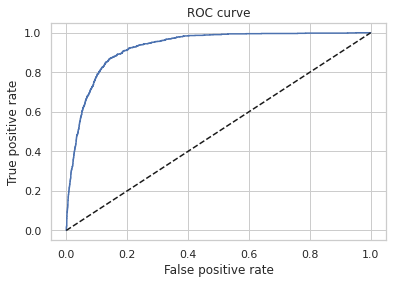

In [ ]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_hat_test_proba)
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [ ]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test, y_hat_test_proba)
AUROC

0.9272712422749175

In [ ]:
#test accuracy
accuracy_score(y_test, y_hat_test)

0.8797965277009842

In [ ]:
#recall for positive labels (how much of successfull contacts we got right)
#baseline naive classifier (predicting most frequent class) would score 0 here
recall_score(y_test, y_hat_test)

0.8062381852551985

In [ ]:
#recall for negative labels (how much of unsuccessfull contacts we got right)
#baseline naive classifier would score 1 here
recall_score(y_test, y_hat_test, pos_label=0)

0.8895428929242329

We got somewhat better predictions compared to WoE binning + LogReg, now let's see if we can interpret results w/ SHAP

Switch to GPU

In [ ]:
booster_xgb = pipeline[0].get_booster()

In [ ]:
shap_val = booster_xgb.predict(xgboost.DMatrix(X_train, y_train), pred_contribs=True)

In [ ]:
shap_val.shape

(36168, 32)

In [ ]:

data_dum = dummy_creation(data.drop('y',axis=1), ['job'])
data_dum.drop('job', axis=1, inplace=True)

In [ ]:
data_dum

,age,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,has job,was reached,season,has couple,job:admin.,job:blue-collar,job:entrepreneur,job:housemaid,job:management,job:retired,job:self-employed,job:services,job:student,job:technician,job:unemployed,job:unknown
0,58,married,tertiary,no,2143,yes,no,unknown,5,5,261,1,-1,0,unknown,1,0,spring,1,0,0,0,0,1,0,0,0,0,0,0,0
1,44,single,secondary,no,29,yes,no,unknown,5,5,151,1,-1,0,unknown,1,0,spring,0,0,0,0,0,0,0,0,0,0,1,0,0
2,33,married,secondary,no,2,yes,yes,unknown,5,5,76,1,-1,0,unknown,1,0,spring,1,0,0,1,0,0,0,0,0,0,0,0,0
3,47,married,unknown,no,1506,yes,no,unknown,5,5,92,1,-1,0,unknown,1,0,spring,1,0,1,0,0,0,0,0,0,0,0,0,0
4,33,single,unknown,no,1,no,no,unknown,5,5,198,1,-1,0,unknown,unknown,0,spring,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,married,tertiary,no,825,no,no,cellular,17,11,977,3,-1,0,unknown,1,0,autumn,1,0,0,0,0,0,0,0,0,0,1,0,0
45207,71,divorced,primary,no,1729,no,no,cellular,17,11,456,2,-1,0,unknown,0,0,autumn,0,0,0,0,0,0,1,0,0,0,0,0,0
45208,72,married,secondary,no,5715,no,no,cellular,17,11,1127,5,184,3,success,0,1,autumn,1,0,0,0,0,0,1,0,0,0,0,0,0
45209,57,married,secondary,no,668,no,no,telephone,17,11,508,4,-1,0,unknown,1,0,autumn,1,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
pd.DataFrame(shap_val[:,:-1], columns=data_dum.columns.tolist())

,age,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,has job,was reached,season,has couple,job:admin.,job:blue-collar,job:entrepreneur,job:housemaid,job:management,job:retired,job:self-employed,job:services,job:student,job:technician,job:unemployed,job:unknown
0,-0.140751,0.310220,-0.009081,0.001905,0.020393,0.233825,0.051918,0.145064,-0.215753,0.034045,-1.172688,-0.162867,-0.091817,-0.047691,-0.183877,0.003429,0.0,-0.198391,0.0,-0.031856,0.030134,0.001081,0.006149,-0.002981,0.029287,0.011392,0.001432,0.000371,0.015362,0.0,0.0
1,0.274485,0.165294,-0.096548,-0.005178,0.197837,0.303088,0.042168,0.128523,-0.152527,0.175127,2.345667,0.034130,-0.187834,0.196139,-0.223053,0.048804,0.0,-0.053315,0.0,-0.011804,0.029125,0.008769,0.009692,0.002130,0.021733,0.009825,-0.010512,0.000178,0.005089,0.0,0.0
2,-0.008746,0.166338,-0.021853,-0.004174,-0.089802,-0.041742,0.008955,0.116389,0.163094,-0.318181,3.119757,-0.164023,-0.087113,-0.051389,-0.089084,-0.002851,0.0,0.020687,0.0,-0.042601,0.012595,0.000594,0.012128,0.017683,0.005977,0.011301,-0.000891,-0.000988,-0.002074,0.0,0.0
3,-0.209497,-0.190542,0.002316,0.003499,-0.555131,0.259040,0.033191,-0.089741,-0.184095,-0.576440,-6.695433,-0.405174,-0.224198,-0.059181,-0.137730,-0.019524,0.0,-0.203779,0.0,-0.044636,0.031644,-0.003191,-0.002049,-0.002309,0.036548,0.005016,0.005290,-0.005407,-0.003127,0.0,0.0
4,-0.141903,-0.152770,-0.008499,0.001660,0.036662,0.169443,0.032638,0.062031,0.320784,-0.618937,-5.783237,-1.021667,-0.168630,-0.063172,-0.138538,-0.105313,0.0,-0.197701,0.0,-0.047517,0.036108,-0.003138,0.003008,-0.005018,0.044380,0.009735,0.001976,-0.004233,0.013304,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,-0.316119,-0.150249,0.001660,-0.000620,-0.032992,-0.155433,0.028876,0.105552,-0.557324,-0.733258,-6.208666,-0.092409,-0.149149,-0.063850,-0.160397,-0.099347,0.0,-0.140043,0.0,-0.028541,-0.296846,0.001116,0.001136,-0.004951,0.011284,0.009784,0.008444,-0.000817,-0.004535,0.0,0.0
36164,-0.119817,0.151776,-0.030542,0.003223,-0.230198,-0.207671,0.040869,0.176973,-0.021336,-0.929803,-3.704104,-0.438120,-0.119040,-0.054437,-0.156017,-0.002919,0.0,-0.146496,0.0,0.134715,0.031644,0.000951,0.005581,0.002845,0.032724,0.007262,0.002024,-0.004718,-0.003096,0.0,0.0
36165,0.063883,-0.169265,0.005978,-0.000096,-0.264243,-0.244257,0.041917,0.182598,0.165897,-0.800020,-2.259508,0.299130,-0.107458,-0.063298,-0.180273,0.001160,0.0,-0.148286,0.0,-0.019933,0.018717,0.001685,0.003259,-0.002309,0.011999,0.005717,0.008444,-0.004718,-0.003522,0.0,0.0
36166,0.019422,0.124287,0.136035,0.002146,0.246451,-0.481831,0.064241,0.437411,-0.085389,-0.591460,-0.535386,0.041819,0.031539,-0.034058,-0.178634,0.002167,0.0,0.037588,0.0,-0.011905,0.033607,0.006342,0.004175,0.000298,0.021889,0.010618,0.001740,-0.001059,-0.001719,0.0,0.0


In [ ]:
pip install shap

     |████████████████████████████████| 371 kB 11.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509236 sha256=a5a491130483e2a6ce656d80ffe2bfb0e9985ec192104479bcc633cd074c1ebf
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [ ]:
import shap

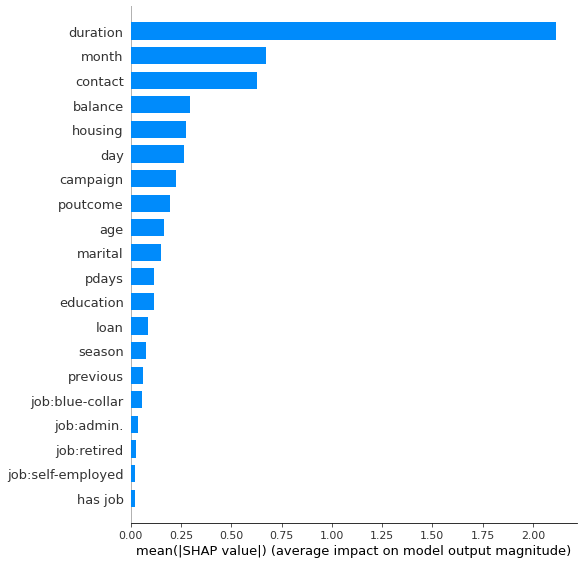

In [ ]:
shap.summary_plot(shap_val[:,:-1], X_train, feature_names=data_dum.columns, plot_type='bar')

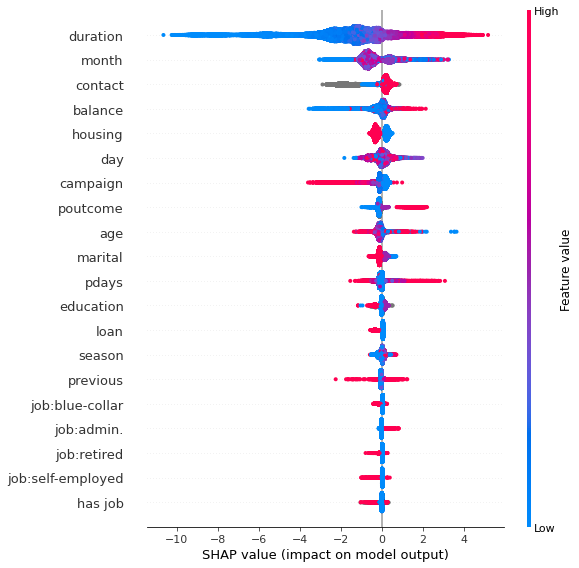

In [ ]:
shap.summary_plot(shap_val[:,:-1], X_train, feature_names=data_dum.columns)

XGBoost seems to trate contact duration as the most important feature. Same conclusion, low duration results in rejection (or is a result of one - again, Shapley values do not prove causality). Same applies to balance, which may stimulate to consider tagging rich clients, however, with no loans.

We can't see 'default' feature here; 'day', 'age' and 'contact' features, although present as somewhat influential, don't seem to have steady unified influence (we dropped these features at LogReg stage).

Overall, SHAP didn't really help here as most features are heavily centered or have negative values influencing predictions in both directions.

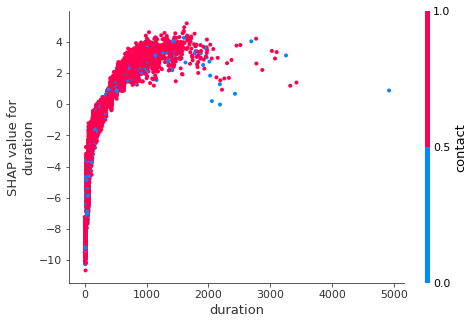

In [ ]:
shap.dependence_plot("duration", shap_val[:,:-1], X_train, interaction_index="auto")

Our most influential feaature most strongly interacts with contact type. It seems to be slightly positive trend towars longer communications via cell than via telephone

In [ ]:
shap.initjs()

xgb_explainer = shap.TreeExplainer(pipeline[0])

In [ ]:
%%time
shap_explainer_values_test = xgb_explainer(X_test, y_test)

CPU times: user 6.78 s, sys: 1.95 ms, total: 6.78 s
Wall time: 6.75 s


Consider sample 43965 from the test set. This contact was successfull

In [ ]:
X_test.head(10)

,age,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,has job,was reached,season,has couple,job:admin.,job:blue-collar,job:entrepreneur,job:housemaid,job:management,job:retired,job:self-employed,job:services,job:student,job:technician,job:unemployed,job:unknown
1392,40,2,2,0,640,1,1,NaN,8,5,347,2,-1,0,NaN,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0
7518,44,2,0,0,378,1,0,NaN,30,5,203,2,-1,0,NaN,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0
12007,31,2,0,0,356,1,0,NaN,20,6,228,5,-1,0,NaN,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
5536,36,2,2,0,655,1,0,NaN,23,5,153,4,-1,0,NaN,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0
29816,34,1,0,0,1921,1,0,1,4,2,61,1,-1,0,NaN,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0
18275,41,1,0,0,1138,0,0,1,31,7,283,18,-1,0,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8543,43,2,1,0,2589,0,0,NaN,3,6,38,3,-1,0,NaN,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
43965,64,0,2,0,109,0,0,1,23,6,706,1,225,2,2,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
28083,35,0,0,0,1803,0,0,1,28,1,61,2,-1,0,NaN,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0
25787,44,0,1,0,2279,0,1,1,19,11,105,1,146,1,0,0,1,3,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
y_test[:10]

1392     0
7518     0
12007    0
5536     0
29816    0
18275    0
8543     0
43965    1
28083    0
25787    0
Name: y, dtype: int64

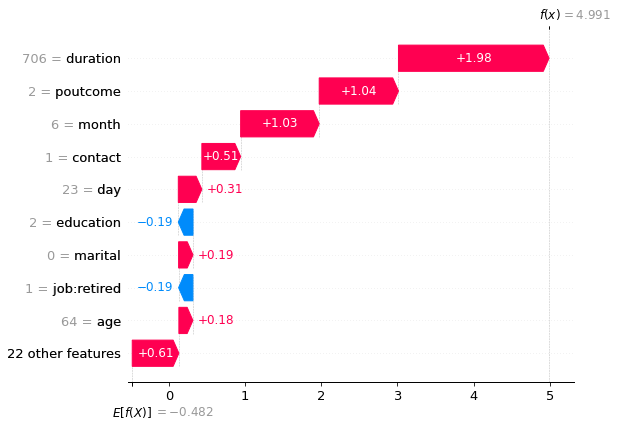

In [ ]:
shap.waterfall_plot(shap_explainer_values_test[7])

Here model correctly predicts positive class, and we can see why. Most of the features positively shifted the outcome from the mean prediction with long duration being the most influential one and successfull previous outcome also affecting.

In the worst case scenario, we could just take a model that makes good predictions and use it to bluntly juggle variables until it predicts positive outcome. This approach, albeit rudimental, frees us from campaign planning and deep understanding of our future capabilities, instead simply playing with what we have at the moment. With relatively low features used it shouldn't take much time.

A separate approach to consider is TabNet neural net. Its authors claim results comparable with gradient boosting models while allowing for high natural interpretability via attention maps. If necessary, TabNet approach could be undertaken within a separate project. Quick experiments didn't show any progress in metrics compared to XGBoost, but it might be revisited later for the sake of explainability. At the same time, dealing with NaNs, outliers, label encoding, normalizing/standardizing the data should be involved.

Clustering could also be tried out as it may allow not to predict the success of the next contact but rather understand patterns within already performed attempts.